Classificação de Imagens usando CNNs e Transfer Learning.

Autor: Arthur Schneider Figueira

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importando Bibliotecas

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-10-31 20:33:41.087006: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 20:33:41.184220: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 20:33:41.573273: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 20:33:41.573291: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 20:33:41.575609: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

[ImageDataGenerator Documentacao](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [4]:
# Caminhos para os diretórios de dados
train_dir = './archive/images/'
validation_dir = '/content/drive/MyDrive/Data Science/Bases/Imagens/Apple_Tomatoes/test'

In [5]:
import os
import shutil
import random

# Definindo as pastas originais e as pastas de destino para treino e teste
src_dir = 'archive/images'
train_dir = 'archive/train'
validation_dir = 'archive/test'

# Definindo a proporção de imagens para teste
test_ratio = 0.2

# Criando pastas de treino e teste se elas não existirem
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)

# Iterando pelas pastas de categorias (neste caso, chitas e leões)
for category in ['Cheetahs', 'Lions']:
    image_files = os.listdir(os.path.join(src_dir, category))
    
    # Embaralhando os nomes dos arquivos para garantir uma divisão aleatória
    random.shuffle(image_files)

    # Calculando o número de imagens para teste
    n_test = int(len(image_files) * test_ratio)
    
    # Criando pastas de categoria em treino e teste
    if not os.path.exists(os.path.join(train_dir, category)):
        os.makedirs(os.path.join(train_dir, category))
    if not os.path.exists(os.path.join(validation_dir, category)):
        os.makedirs(os.path.join(validation_dir, category))
    
    # Movendo as imagens para as respectivas pastas
    for i, img_file in enumerate(image_files):
        src_path = os.path.join(src_dir, category, img_file)
        if i < n_test:
            dst_path = os.path.join(validation_dir, category, img_file)
        else:
            dst_path = os.path.join(train_dir, category, img_file)
        
        shutil.move(src_path, dst_path)


### ImageDataGenerator

Faz com que as imagens sejam manipuladas artificialmente.

* rescale: multiplica o valor dos pixels pelos valores;
* rotation_range: A imagem poderá sofrer uma rotação;
* width_shift_range e height_shift_range: move a imagem horizontalmente e verticalmente;
* zoom_range: aplica um zoom na imagem;
* horizontal_flip: gira a imagem;
* modo para preencher os valores além da borda da imagem.


In [6]:
#Visto que há pouca amostra, vamos usar o ImageDataGenerator para ampliar a amostragem

# Pré-processamento e aumento de dados
train_datagen = ImageDataGenerator(
    #rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

In [7]:
# Carregando imagens do diretório e aplicando o pré-processamento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [8]:
# Construindo a CNN
model = tf.keras.models.Sequential([
    # Input shape 224x224 e 3 camadas
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    # Com Conv2D (32), o shape passa a ser 224x224x32. É como se fossem 32 neurônios com output 224x224
    tf.keras.layers.MaxPooling2D(2, 2),
    # Com o maxpooling (2x2), o shape passa a ser 112x112x32
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # Com Conv2D (64), o shape passa a ser 112x112x64
    tf.keras.layers.MaxPooling2D(2, 2),
    # Com o maxpooling (2x2), o shape passa a ser 56x56x64
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # Com Conv2D (128), o shape passa a ser 56x56x128
    tf.keras.layers.MaxPooling2D(2, 2),
    # Com o maxpooling (2x2), o shape passa a ser 28x28x128
    tf.keras.layers.Flatten(),
    # Com o Flatten, torna-se um vetor 28x28x128 = 100.352
    tf.keras.layers.Dense(512, activation='relu'),
    # Camada densa com 512 saídas
    tf.keras.layers.Dense(1, activation='sigmoid')
    #Camada final com 1 saída sigmoid
])

# Compilando o modelo
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Treinamento do modelo
history = model.fit(
    train_generator,
    #steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    #validation_steps=50
)

2023-10-31 20:33:43.962104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 20:33:43.962683: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/15
5/5 [==============================] - 3s 462ms/step - loss: 5958.0190 - accuracy: 0.5250 - val_loss: 0.8325 - val_accuracy: 0.5000
Epoch 2/15
5/5 [==============================] - 2s 424ms/step - loss: 45.0106 - accuracy: 0.4250 - val_loss: 0.6943 - val_accuracy: 0.5750
Epoch 3/15
5/5 [==============================] - 2s 422ms/step - loss: 1.2041 - accuracy: 0.5437 - val_loss: 0.6930 - val_accuracy: 0.4750
Epoch 4/15
5/5 [==============================] - 2s 423ms/step - loss: 0.9295 - accuracy: 0.5625 - val_loss: 0.6938 - val_accuracy: 0.4500
Epoch 5/15
5/5 [==============================] - 2s 420ms/step - loss: 1.1690 - accuracy: 0.5188 - val_loss: 0.6933 - val_accuracy: 0.4750
Epoch 6/15
5/5 [==============================] - 2s 425ms/step - loss: 0.6892 - accuracy: 0.6187 - val_loss: 0.6934 - val_accuracy: 0.4750
Epoch 7/15
5/5 [==============================] - 2s 427ms/step - loss: 0.8728 - accuracy: 0.5437 - val_loss: 0.6933 - val_accuracy: 0.4500
Epoch 8/15
5/5 [

In [9]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Treinamento do modelo
history_2 = model2.fit(
    train_generator,
    #steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    #validation_steps=50
)

Epoch 1/15
5/5 [==============================] - 3s 437ms/step - loss: 1962.1484 - accuracy: 0.4938 - val_loss: 0.6924 - val_accuracy: 0.5750
Epoch 2/15
5/5 [==============================] - 2s 393ms/step - loss: 11.6832 - accuracy: 0.4938 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/15
5/5 [==============================] - 2s 396ms/step - loss: 0.9279 - accuracy: 0.5125 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/15
5/5 [==============================] - 2s 397ms/step - loss: 0.7166 - accuracy: 0.5562 - val_loss: 0.7003 - val_accuracy: 0.5000
Epoch 5/15
5/5 [==============================] - 2s 390ms/step - loss: 6.7384 - accuracy: 0.4875 - val_loss: 0.6928 - val_accuracy: 0.5250
Epoch 6/15
5/5 [==============================] - 2s 386ms/step - loss: 0.9458 - accuracy: 0.5562 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 7/15
5/5 [==============================] - 2s 397ms/step - loss: 2.4421 - accuracy: 0.6375 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 8/15
5/5 [

In [10]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Treinamento do modelo
history_3 = model3.fit(
    train_generator,
    #steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    #validation_steps=50
)

Epoch 1/15
5/5 [==============================] - 3s 442ms/step - loss: 1096.8387 - accuracy: 0.4437 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/15
5/5 [==============================] - 2s 394ms/step - loss: 10.0007 - accuracy: 0.5125 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/15
5/5 [==============================] - 2s 382ms/step - loss: 1.5363 - accuracy: 0.5125 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/15
5/5 [==============================] - 2s 385ms/step - loss: 1.0654 - accuracy: 0.5375 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 5/15
5/5 [==============================] - 2s 391ms/step - loss: 1.8283 - accuracy: 0.4688 - val_loss: 0.6961 - val_accuracy: 0.5000
Epoch 6/15
5/5 [==============================] - 2s 390ms/step - loss: 3.6595 - accuracy: 0.5063 - val_loss: 0.6931 - val_accuracy: 0.5250
Epoch 7/15
5/5 [==============================] - 2s 390ms/step - loss: 0.8495 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 8/15
5/5 [

### **train_generator**

A base de treino é composta por 294 imagens.

Em **train_generator**, usamos batch size = 32. Portando, estamos capturando de 32 em 32 imagens.

No histórico de treinamento (**history = model.fit(epochs=15)**), estamos considerando um treinamento por 15 épocas.

A cada época temos:294 imagens sendo treinadas.

Ao concluir a época, os inputs passarão novamente por train_generator. Portanto, a tendência é que sejam 294 imagens diferentes.

Logo, a quantidade de imagens * epoch = base de treinamento. Logo, teremos 294 x 15 =  4.410 imagens como base de treino.

Já o parâmetro **validation_generator** não está alterando as imagens. Estamos usando 97 imagens para validar.

# Transfer Learning

[Documentação e exemplos de redes pré-treinadas](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

[MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2)

Input Shape:
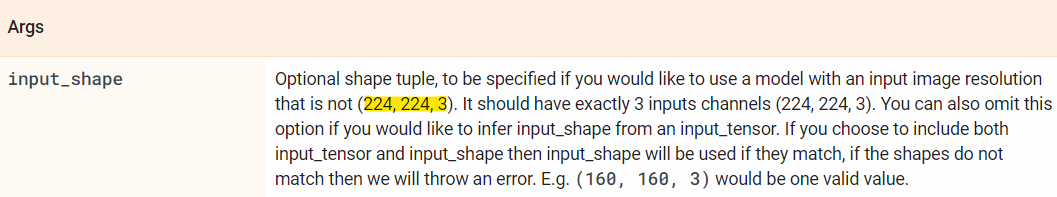

In [11]:
MobileNetV2 = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
#Nao vamos permitir que o valor dos pesos/bias sejam alterados nessa rede
MobileNetV2.trainable = False

In [12]:
model_TransferLearning_MobileNetV2 = tf.keras.Sequential([
    MobileNetV2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Substitua num_classes pelo número de classes em seu problema
])

In [13]:
# Compilando o modelo
model_TransferLearning_MobileNetV2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Treinamento do modelo
history_MobileNetV2 = model_TransferLearning_MobileNetV2.fit(
    train_generator,
    #steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    #validation_steps=50
)

Epoch 1/15
5/5 [==============================] - 3s 444ms/step - loss: 2.0037 - accuracy: 0.4500 - val_loss: 0.8410 - val_accuracy: 0.4500
Epoch 2/15
5/5 [==============================] - 2s 326ms/step - loss: 0.7777 - accuracy: 0.5562 - val_loss: 0.7510 - val_accuracy: 0.4500
Epoch 3/15
5/5 [==============================] - 2s 327ms/step - loss: 0.6307 - accuracy: 0.6250 - val_loss: 0.7870 - val_accuracy: 0.5000
Epoch 4/15
5/5 [==============================] - 2s 330ms/step - loss: 0.7673 - accuracy: 0.5750 - val_loss: 0.8032 - val_accuracy: 0.5000
Epoch 5/15
5/5 [==============================] - 2s 336ms/step - loss: 0.6783 - accuracy: 0.5875 - val_loss: 0.7411 - val_accuracy: 0.5250
Epoch 6/15
5/5 [==============================] - 2s 328ms/step - loss: 0.6834 - accuracy: 0.5625 - val_loss: 0.8161 - val_accuracy: 0.5250
Epoch 7/15
5/5 [==============================] - 2s 332ms/step - loss: 0.7456 - accuracy: 0.5500 - val_loss: 0.7264 - val_accuracy: 0.5750
Epoch 8/15
5/5 [====

# DenseNEt

In [14]:
DenseNet = tf.keras.applications.densenet.DenseNet201(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
#Nao vamos permitir que o valor dos pesos/bias sejam alterados nessa rede
DenseNet.trainable = False

In [15]:
model_TransferLearning_DenseNet = tf.keras.Sequential([
    DenseNet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Substitua num_classes pelo número de classes em seu problema
])

In [16]:
# Compilando o modelo
model_TransferLearning_DenseNet.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Treinamento do modelo
history_DenseNet = model_TransferLearning_DenseNet.fit(
    train_generator,
    #steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    #validation_steps=50
)

Epoch 1/15
5/5 [==============================] - 8s 1s/step - loss: 5.1952 - accuracy: 0.5188 - val_loss: 0.9490 - val_accuracy: 0.5000
Epoch 2/15
5/5 [==============================] - 3s 609ms/step - loss: 1.6801 - accuracy: 0.5938 - val_loss: 0.8071 - val_accuracy: 0.5250
Epoch 3/15
5/5 [==============================] - 3s 607ms/step - loss: 0.6535 - accuracy: 0.7125 - val_loss: 0.8735 - val_accuracy: 0.5000
Epoch 4/15
5/5 [==============================] - 3s 603ms/step - loss: 0.9697 - accuracy: 0.6125 - val_loss: 0.7397 - val_accuracy: 0.5500
Epoch 5/15
5/5 [==============================] - 3s 604ms/step - loss: 0.5703 - accuracy: 0.7125 - val_loss: 0.8032 - val_accuracy: 0.5000
Epoch 6/15
5/5 [==============================] - 3s 601ms/step - loss: 0.6738 - accuracy: 0.7250 - val_loss: 0.8900 - val_accuracy: 0.5000
Epoch 7/15
5/5 [==============================] - 3s 601ms/step - loss: 0.6348 - accuracy: 0.7250 - val_loss: 0.6869 - val_accuracy: 0.5750
Epoch 8/15
5/5 [=======

# Avaliando

In [17]:
import os

In [18]:
cheetahs = ['archive/test/Cheetahs/'+f for f in os.listdir('archive/test/Cheetahs')]

In [19]:
lions = ['archive/test/Lions/'+f for f in os.listdir('archive/test/Lions')]

In [20]:
cheetahs[0]

'archive/test/Cheetahs/02a0439923768403.jpg'

In [21]:
from PIL import Image

# Carrega a imagem
image_path = cheetahs[0]
image = Image.open(image_path).convert("RGB")

image = image.resize((224, 224))

# Converte a imagem para um array numpy e normaliza os valores de pixel
import numpy as np

image_array = np.array(image)

In [22]:
image_array = np.array(image) / 255.0 
input_image = np.expand_dims(image_array, axis=0)

In [23]:
# Faça a previsão usando o modelo
predictions = model.predict(input_image)

# Decodifique as previsões (dependendo do seu problema, pode ser necessário um passo adicional de decodificação)
classe_predita = np.argmax(predictions, axis=1)[0]

1/1 [==============================] - 0s 50ms/step


# Preditos

A classe que aparece primeiro no diretorio vale 0 e a segunda vale 1. Portanto 0 = apple e 1 = tomatoes.

In [26]:
animals,path,model_1,model_2,model_3,model_Mobile,model_DnsNet = [],[],[],[],[],[],[]

for image_path in cheetahs:
  image = Image.open(image_path).convert("RGB")
  image = image.resize((224, 224))
  image_array = np.array(image) / 255.0  # Normalize para [0,1]
  input_image = np.expand_dims(image_array, axis=0)

  predictions = model.predict(input_image)
  if float(predictions) > 0.5:
    classe_predita = 1
  else:
    classe_predita = 0

  predictions2 = model_TransferLearning_MobileNetV2.predict(input_image)
  if float(predictions2) > 0.5:
    classe_predita2 = 1
  else:
    classe_predita2 = 0

  predictions3 = model_TransferLearning_DenseNet.predict(input_image)
  if float(predictions3) > 0.5:
    classe_predita3 = 1
  else:
    classe_predita3 = 0
  
  predictions = model2.predict(input_image)
  if float(predictions) > 0.5:
    classe_predita4 = 1
  else:
    classe_predita4 = 0

  predictions = model3.predict(input_image)
  if float(predictions) > 0.5:
    classe_predita5 = 1
  else:
    classe_predita5 = 0



  animals.append('cheetahs')
  path.append(image_path)
  model_1.append(classe_predita)
  model_Mobile.append(classe_predita2)
  model_DnsNet.append(classe_predita3)
  model_2.append(classe_predita4)
  model_3.append(classe_predita5)

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1132467/3929110284.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if float(predictions) > 0.5:
/tmp/ipykernel_1132467/3929110284.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if float(predictions2) > 0.5:
/tmp/ipykernel_1132467/3929110284.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if float(predictions3) > 0.5:
/tmp/ipykernel_1132467/3929110284.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprec

1/1 [==============================] - 0s 10ms/step


In [ ]:
len(animals),len(model_1),len(model_2),len(model_3),len(model_Mobile),len(model_DnsNet)

(20, 20, 20, 20, 20, 20)

In [27]:
for image_path in lions:
  image = Image.open(image_path).convert("RGB")
  image = image.resize((224, 224))
  image_array = np.array(image) / 255.0  # Normalize para [0,1]
  input_image = np.expand_dims(image_array, axis=0)

  predictions = model.predict(input_image)
  if float(predictions) > 0.5:
    classe_predita = 1
  else:
    classe_predita = 0

  predictions2 = model_TransferLearning_MobileNetV2.predict(input_image)
  if float(predictions2) > 0.5:
    classe_predita2 = 1
  else:
    classe_predita2 = 0

  predictions3 = model_TransferLearning_DenseNet.predict(input_image)
  if float(predictions3) > 0.5:
    classe_predita3 = 1
  else:
    classe_predita3 = 0

  predictions = model2.predict(input_image)
  if float(predictions) > 0.5:
    classe_predita4 = 1
  else:
    classe_predita4 = 0

  predictions = model3.predict(input_image)
  if float(predictions) > 0.5:
    classe_predita5 = 1
  else:
    classe_predita5 = 0



  animals.append('lions')
  path.append(image_path)
  model_1.append(classe_predita)
  model_Mobile.append(classe_predita2)
  model_DnsNet.append(classe_predita3)
  model_2.append(classe_predita4)
  model_3.append(classe_predita5)

1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1132467/4088419180.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if float(predictions) > 0.5:
/tmp/ipykernel_1132467/4088419180.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if float(predictions2) > 0.5:
/tmp/ipykernel_1132467/4088419180.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if float(predictions3) > 0.5:
/tmp/ipykernel_1132467/4088419180.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is depreca

1/1 [==============================] - 0s 10ms/step


In [28]:
len(animals),len(model_1),len(model_2),len(model_3),len(model_Mobile),len(model_DnsNet)

(40, 40, 40, 40, 40, 40)

In [29]:
import pandas as pd
data = {'animals': animals, 'model_1': model_1, 'model_2': model_2, 'model_3': model_3, 'model_Mobile':model_Mobile,'model_DnsNet':model_DnsNet,'path':path}
df_resultado = pd.DataFrame.from_dict(data)
df_resultado

,animals,model_1,model_2,model_3,model_Mobile,model_DnsNet,path
0,cheetahs,0,1,0,1,1,archive/test/Cheetahs/02a0439923768403.jpg
1,cheetahs,1,1,0,1,0,archive/test/Cheetahs/0db6601682a368e8.jpg
2,cheetahs,0,0,0,0,1,archive/test/Cheetahs/a9be4e0ac3ff7f4e.jpg
3,cheetahs,0,1,0,1,0,archive/test/Cheetahs/c65aae5dd1d75984.jpg
4,cheetahs,0,1,0,1,1,archive/test/Cheetahs/7f33de86429cef7f.jpg
5,cheetahs,0,0,0,1,0,archive/test/Cheetahs/0c6e90e19f2b2bbc.jpg
6,cheetahs,0,0,0,1,0,archive/test/Cheetahs/0c20fa69621a2e6c.jpg
7,cheetahs,0,1,0,1,1,archive/test/Cheetahs/02a5846a35629f1d.jpg
8,cheetahs,0,1,0,1,0,archive/test/Cheetahs/ebd1867dacf535c7.jpg
9,cheetahs,0,1,0,1,1,archive/test/Cheetahs/4a15bd602934d7aa.jpg


In [30]:
df_resultado.groupby(['animals','model_1'])['model_1'].agg(['count'])

count
animals  model_1       
cheetahs 0           19
         1            1
lions    0           20

In [31]:
df_resultado.groupby(['animals','model_2'])['model_2'].agg(['count'])

count
animals  model_2       
cheetahs 0            7
         1           13
lions    0            8
         1           12

In [32]:
df_resultado.groupby(['animals','model_3'])['model_3'].agg(['count'])

,,count
animals,model_3,
cheetahs,0,20
lions,0,20


In [33]:
df_resultado.groupby(['animals','model_Mobile'])['model_Mobile'].agg(['count'])

count
animals  model_Mobile       
cheetahs 0                 1
         1                19
lions    1                20

In [42]:
df_resultado.groupby(['animals','model_DnsNet'])['model_DnsNet'].agg(['count'])

count
animals  model_DnsNet       
cheetahs 0                10
         1                10
lions    0                 4
         1                16

## Conclusão:

O melhor modelo foi o **model_DnsNet**.

In [35]:
# from google.colab.patches import cv2_imshow
import cv2

In [36]:
df_resultado.tail()

,animals,model_1,model_2,model_3,model_Mobile,model_DnsNet,path
35,lions,0,0,0,1,1,archive/test/Lions/db3c6efce3109e80.jpg
36,lions,0,1,0,1,1,archive/test/Lions/06c269f657184270.jpg
37,lions,0,1,0,1,1,archive/test/Lions/ccea45f05d866cd6.jpg
38,lions,0,1,0,1,1,archive/test/Lions/0f0e1c3f75d2a442.jpg
39,lions,0,1,0,1,1,archive/test/Lions/0c6d0c1a263244b9.jpg


In [44]:
#0 = apple e fruta = tomate. Portanto, foi um erro
df_resultado.loc[(df_resultado.model_DnsNet == 0) & (df_resultado.animals == 'lions'),'path']

21    archive/test/Lions/691ec9943cac126b.jpg
23    archive/test/Lions/c48af09db98b16e2.jpg
26    archive/test/Lions/002b54a615993dca.jpg
31    archive/test/Lions/eb551b1c169fe188.jpg
Name: path, dtype: object

Acertos